# Segment Anything Model for Microscopy (Micro-SAM)

In this notebook we will use Micro-SAM for segmenting objects in immunoflourescence microscopy images.

This notebook was deeply inspired and partially copy-pasted by the [automatic-segmentation notebook in the micro-sam github repository](https://github.com/computational-cell-analytics/micro-sam/blob/master/notebooks/automatic_segmentation.ipynb) (licensed [MIT](https://github.com/computational-cell-analytics/micro-sam/tree/master?tab=MIT-1-ov-file#readme)): 


## Installing dependencies
To make this notebook work, you need to install [micro-sam](https://github.com/computational-cell-analytics/micro-sam/), e.g. using mamba:

```
mamba install -c conda-forge micro_sam=1.0.1 -c pytorch
```

```
pip install h5py==3.10
```


In [1]:
import os
from glob import glob

import h5py
import matplotlib.pyplot as plt
from skimage.measure import label as connected_components

from micro_sam import util
from micro_sam.evaluation.model_comparison import _enhance_image
from micro_sam.instance_segmentation import (
    InstanceSegmentationWithDecoder,
    AutomaticMaskGenerator,
    get_predictor_and_decoder,
    mask_data_to_segmentation
)

import stackview

As example image, we use data published by C. Pape, licensed [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/): https://zenodo.org/records/5092850

StackViewNDArray([[2754.1335, 2604.1997, 2449.295 , ..., 3070.6455,
                   3062.2837, 2806.511 ],
                  [2259.7515, 2748.2964, 2710.61  , ..., 3058.901 ,
                   3156.6233, 3076.788 ],
                  [2449.6155, 2572.245 , 2465.6729, ..., 3472.6719,
                   2833.348 , 3069.2974],
                  ...,
                  [1475.0198, 1983.5216, 1607.8248, ..., 2995.758 ,
                   2554.3853, 2674.6382],
                  [1753.3606, 1684.0425, 1684.5452, ..., 2519.3564,
                   2408.866 , 2647.7917],
                  [1652.695 , 1762.9921, 1546.2175, ..., 2505.1743,
                   2266.2495, 2542.2002]], dtype=float32)
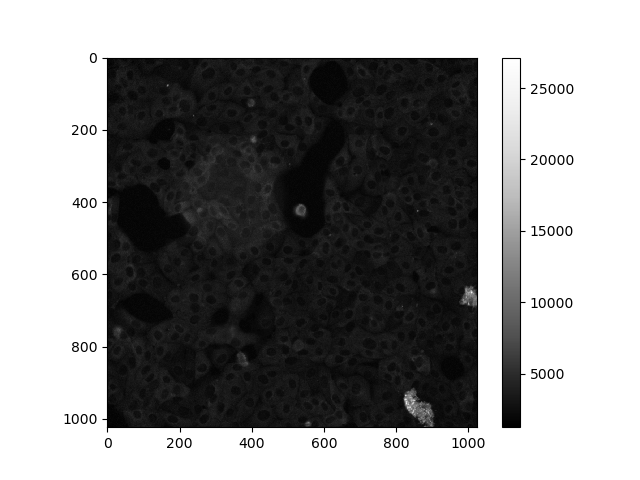
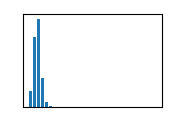

In [2]:
filename = "data/gt_image_000.h5"

with h5py.File(filename, "r") as h5file:
    image = h5file["raw/serum_IgG/s0"][:]
    labels = h5file["labels/cells/s0"][:]

stackview.insight(image)

### Next, we create convenience functions for automatic segmentation methods

In [5]:
def run_automatic_instance_segmentation(image, model_type="vit_b_lm"):
    """Automatic Instance Segmentation by training an additional instance decoder in SAM.

    NOTE: It is supported only for `µsam` models.
    
    Args:
        image: The input image.
        model_type: The choice of the `µsam` model.
        
    Returns:
        The instance segmentation.
    """
    # Step 1: Initialize the model attributes using the pretrained µsam model weights.
    #   - the 'predictor' object for generating predictions using the Segment Anything model.
    #   - the 'decoder' backbone (for AIS).
    predictor, decoder = get_predictor_and_decoder(
        model_type=model_type,  # choice of the Segment Anything model
        checkpoint_path=None,  # overwrite to pass our own finetuned model
    )
    
    # Step 2: Computation of the image embeddings from the vision transformer-based image encoder.
    image_embeddings = util.precompute_image_embeddings(
        predictor=predictor,  # the predictor object responsible for generating predictions
        input_=image,  # the input image
        ndim=2,  # number of input dimensions
    )
    
    # Step 3: Combining the decoder with the Segment Anything backbone for automatic instance segmentation.
    ais = InstanceSegmentationWithDecoder(predictor, decoder)
    
    # Step 4: Initializing the precomputed image embeddings to perform faster automatic instance segmentation.
    ais.initialize(
        image=image,  # the input image
        image_embeddings=image_embeddings,  # precomputed image embeddings
    )

    # Step 5: Getting automatic instance segmentations for the given image and applying the relevant post-processing steps.
    prediction = ais.generate()
    prediction = mask_data_to_segmentation(prediction, with_background=True)
    
    return prediction


def run_automatic_mask_generation(image, model_type="vit_b"):
    """Automatic Mask Generation.
    
    NOTE: It is supported for both Segment Anything models and µsam models.
    
    Args:
        image: The input image.
        model_type: The choice of the `SAM` / `µsam` model.
        
    Returns:
        The instance segmentation.
    """
    # Step 1: Initialize the model attributes using the pretrained SAM / µsam model weights.
    #   - the 'predictor' object for generating predictions using the Segment Anything model.
    predictor = util.get_sam_model(
        model_type=model_type,  # choice of the Segment Anything model
    )
    
    # Step 2: Computation of the image embeddings from the vision transformer-based image encoder.
    image_embeddings = util.precompute_image_embeddings(
        predictor=predictor,  # the predictor object responsible for generating predictions
        input_=image,  # the input image
        ndim=2,  # number of input dimensions
    )
    
    # Step 3: Initializing the predictor for automatic mask generation.
    amg = AutomaticMaskGenerator(predictor)
    
    # Step 4: Initializing the precomputed image embeddings to perform automatic segmentation using automatic mask generation.
    amg.initialize(
        image=image,  # the input image
        image_embeddings=image_embeddings,  # precomputed image embeddings
    )
    
    # Step 5: Getting automatic instance segmentations for the given image and applying the relevant post-processing steps.
    #  - the parameters for `pred_iou_thresh` and `stability_score_thresh` are lowered (w.r.t the defaults) to observe the AMG outputs for the microscopy domain.
    prediction = amg.generate(
        pred_iou_thresh=0.75,
        stability_score_thresh=0.75
    )
    prediction = mask_data_to_segmentation(prediction, with_background=True)
    
    return prediction

Compute Image Embeddings 2D.: 100%|██████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.29s/it]


StackViewNDArray([[0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
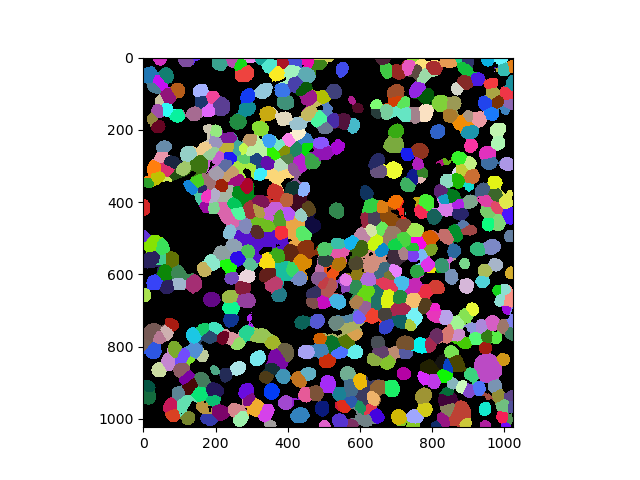

In [6]:
result = run_automatic_instance_segmentation(image)
stackview.insight(result)

# Exercise
After the model worked successfully on your data, consider deleting the model files from the folder printed above. 
We will not need it anymore.